# 1. Подготовка

In [1]:
#библиотеки 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import torch
import transformers
from tqdm import notebook
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
import re
import nltk
from nltk.stem import WordNetLemmatizer

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


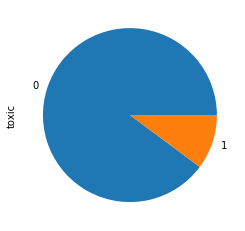

In [4]:
data['toxic'].value_counts().plot(kind = 'pie')

In [5]:
data['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

In [6]:
data.isnull().sum()

text     0
toxic    0
dtype: int64

In [7]:
data.duplicated().sum()

0

Данные открыты и изучены. 

Таблица состоит из двух столбцов. 

Всего исслелований в выборочных данных - 159571.

Пропуски и дубликаты в данных отсутствуют. 

Наибольшая часть комментариев (90%) имеют положительный контекст.

In [8]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(text.split())

clean_questions= []
for question in data['text']: 
    clean_questions.append(clean_text(question))

In [9]:
!pip install textblob
from textblob import TextBlob, Word

lemm_text = []
for lemm in clean_questions:
    lemm_text.append(TextBlob(lemm))

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 636 kB 767 kB/s eta 0:00:01


In [10]:
display(clean_questions[1], lemm_text[1])

'D aww He matches this background colour I m seemingly stuck with Thanks talk January UTC'

TextBlob("D aww He matches this background colour I m seemingly stuck with Thanks talk January UTC")

In [11]:
target = data['toxic']
features = pd.Series(lemm_text)

In [12]:
features_train,features_test,target_train,target_test = train_test_split(features,target,test_size = 0.2,random_state = 42)

In [13]:
#уменьшение выборки 
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

#применение функции
features_train,target_train = downsample(features_train,target_train,0.5)

In [14]:
target_train.value_counts()

0    57338
1    12981
Name: toxic, dtype: int64

In [15]:
#Оценка важности слова в тексте
stopwords = set(nltk_stopwords.words('english'))

features_train = features_train.astype('U')
features_test = features_test.astype('U')

vectorizer = TfidfVectorizer(stop_words=stopwords,use_idf=True)

features_train = vectorizer.fit_transform(features_train)

vectorizer.get_stop_words()

features_test = vectorizer.transform(features_test)

# 2. Обучение

## Модель 1

In [15]:
#выбор значения гиперпараметра max_iter для модели № 1
max_iter_array = [1, 3, 5,6,7,8,9,10,20,25,30,35,40,45,50,55,60,65,70,75,80,90,100]
model = LogisticRegression()
grid = GridSearchCV(model, param_grid={'max_iter': max_iter_array})
grid.fit(features_train,target_train)

best_max_iter = grid.best_estimator_.max_iter
print(grid.best_score_, best_max_iter)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9225102746057253 8


In [16]:
model = LogisticRegression(max_iter =8,random_state = 42)
model.fit(features_train,target_train)
pred = model.predict(features_test)
print(f1_score(target_test,pred))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7611139941186645


/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Модель 2

In [ ]:
#выбор гиперпараметров для модели №2
n_estimators_array = [1, 3, 5, 7, 10, 15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
max_depth_array = [1, 3, 5, 7, 10, 15,20,25]
model_2 = RandomForestClassifier(random_state = 42)
grid = GridSearchCV(model_2, param_grid={'n_estimators': n_estimators_array,'max_depth': max_depth_array})
grid.fit(features_train,target_train)
best_n_estimators = grid.best_estimator_.n_estimators
best_max_depth = grid.best_estimator_.max_depth
print(grid.best_score_, best_n_estimators,best_max_depth)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [21]:
n_estim = list(range(1, 102, 10)) #От 1 до 102 с шагом 10
depth = list(range(1, 25, 3))
display(n_estim, depth)

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

[1, 4, 7, 10, 13, 16, 19, 22]

In [17]:
#случайный лес 
model2 = RandomForestClassifier(random_state = 42,n_estimators=1,max_depth = 25)
model2.fit(features_train,target_train)
pred2 = model2.predict(features_test)
print(f1_score(target_test,pred2))

0.2777777777777778


## Модель 3

In [ ]:
#выбор значения гиперпараметра max_depth для модели № 3
max_depth_array = [1, 3, 5,6, 7, 10, 15,20,25]
model_3 = DecisionTreeClassifier()
grid = GridSearchCV(model_3, param_grid={'max_depth': max_depth_array})
grid.fit(features_train,target_train)
best_max_depth = grid.best_estimator_.max_depth
print(grid.best_score_, best_max_depth)

In [18]:
#модель №3
model3 = DecisionTreeClassifier(random_state = 42,max_depth = 25)
model3.fit(features_train,target_train)
pred3 = model3.predict(features_test)
print(f1_score(target_test, pred3))

0.6659217877094973


## Комментарий наставника
<span style="color:green">Отлично, к модели дерева решений нечего добавить.</span>

Для каждой модели были выбраны оптимальные гперпараметры, и подсчитана доля правильных ответов.

Качество модели № 1 показало наилучший результат со исследуемой метрике.

<font color = blue>
F1-мера модели № 1:0.76111
</font>

F1-мера модели № 2:0.27777

F1-мера модели № 3: 0.66592


### Проверка модели на адекватность

In [19]:
dummy_clf = DummyClassifier()
dummy_clf.fit(features_train,target_train)
pred_check = dummy_clf.predict(features_test)
print(f1_score(target_test, pred_check))

0.1346112427309929


Для проверки модели на адекватность был использован классификатор в качестве простой базовой линии для сравнения с реальными классификаторами. Проверка показала, что модель № 1  дает большую долю правильных ответов, чем используемым для сравнения классификатор, тем самым доказывая адекватность модели.

F1-мера модели № 1: 0.76111

F1-мера дамми-модели: 0.1284623

# 3. Выводы

Данные открыты и изучены. Таблица состоит из двух столбцов. Всего исслелований в выборочных данных - 159571.Пропуски и дубликаты в данных отсутствуют. Наибольшая часть комментариев (90%) имеют положительный контекст.

Для каждой модели были выбраны оптимальные гперпараметры, и подсчитана доля правильных ответов.

Качество модели № 1 показало наилучший результат со исследуемой метрике.

<font color = blue>
F1-мера модели № 1:0.76111
</font>

F1-мера модели № 2:0.27777

F1-мера модели № 3: 0.66592


Для проверки модели на адекватность был использован классификатор в качестве простой базовой линии для сравнения с реальными классификаторами. Проверка показала, что модель № 1  дает большую долю правильных ответов, чем используемым для сравнения классификатор, тем самым доказывая адекватность модели.

F1-мера модели № 1: 0.76111

F1-мера дамми-модели: 0.1284623